In [1]:
!pip install pandas-profiling

You should consider upgrading via the 'c:\users\alex lucchesi\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
from pandas_profiling import ProfileReport
from statsmodels.formula.api import ols
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

## Start with Data Cleaning. Hate working with dirty data

* Cleaned named columns 
* Started with a lot of outliers. Reframed DF using query function and cut down the DF by 25 entries. Dist is still right skewed, but should be better for modeling.
* Verified the NaN count of the DF is zero.
* View distribution of data
* Scatter to see relationship. Appears to be linear

What is the average number of fatalities vs confirmed cases?
What is the ratio of probable cases to confirmed cases?
What makes a probable case?
Which county has the most confirmed cases?
Has that county also experienced an insurgence of homelessness?

In [3]:
# Read in data via pandas read_excel
df = pd.read_excel('CaseCountData (1).xlsx', header=1)

# Rename columns to keep data tidy
df.rename(columns = { "County" : "county", "Confirmed Cases" : "confirmed_cases", "Probable Cases": "probable_cases", "Fatalities":"fatalities"}, inplace=True)

# View DF
display(df.head(10))
print(df.shape)

,county,confirmed_cases,probable_cases,fatalities
0,Anderson,4954.0,2774.0,171
1,Andrews,2637.0,0.0,52
2,Angelina,6546.0,6656.0,356
3,Aransas,1920.0,556.0,56
4,Archer,937.0,140.0,14
5,Armstrong,182.0,76.0,7
6,Atascosa,6387.0,1816.0,188
7,Austin,2600.0,655.0,49
8,Bailey,680.0,297.0,23
9,Bandera,1555.0,597.0,46


(256, 4)


In [4]:
# How does the data look?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   county           256 non-null    object 
 1   confirmed_cases  254 non-null    float64
 2   probable_cases   254 non-null    float64
 3   fatalities       256 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 8.1+ KB


In [5]:
# What does the distribution look like from min to max? Where does the majority of my data fall?
df.describe()

,confirmed_cases,probable_cases,fatalities
count,254.000000,254.000000,256.000000
mean,13224.543307,2614.984252,494.101562
std,49096.554108,7429.531558,4009.248335
min,6.000000,0.000000,0.000000
25%,611.750000,137.000000,23.000000
50%,2058.500000,512.500000,60.500000
75%,5195.250000,1640.750000,167.500000
max,550674.000000,58307.000000,63245.000000


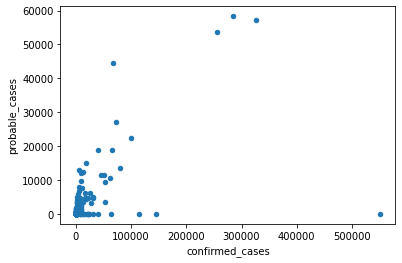

In [6]:
%matplotlib inline
df.plot.scatter(x = 'confirmed_cases',
                y = 'probable_cases');

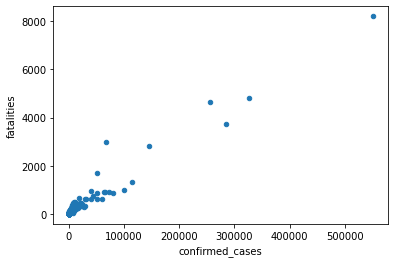

In [7]:
df.plot.scatter(x = "confirmed_cases",
                y = "fatalities");

<AxesSubplot:xlabel='fatalities', ylabel='probable_cases'>

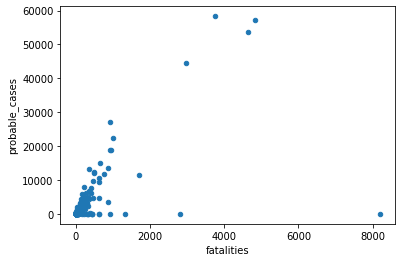

In [8]:
df.plot.scatter(x = 'fatalities',
                y = 'probable_cases')

array([[<AxesSubplot:title={'center':'confirmed_cases'}>,
        <AxesSubplot:title={'center':'probable_cases'}>],
       [<AxesSubplot:title={'center':'fatalities'}>, <AxesSubplot:>]],
      dtype=object)

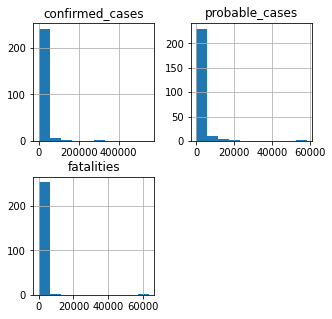

In [9]:
df.hist(figsize=(5,5))

* The lower the confirmed cases, the higher the probable cases
* Confirmed cases and fatalities move in a linear fashion. We could speculate a relationship between the two
* The lower the fatalities, the higher the probable cases. This is at almost a perfect correlation as you have a very slight slope on the line, meaning the correlation should be close to 1.
* Probable cases also has the same form of correlation between Confirmed cases. This category may be causing the model to overfit and generalize to the training data, placing too much weight on how probable cases factor in.

In [10]:
# Query data to show without outliers.
df1 = df.query("confirmed_cases <= 10000 and confirmed_cases >=400 and probable_cases <= 10000")
display(df1.head())
print(df1.shape)

,county,confirmed_cases,probable_cases,fatalities
0,Anderson,4954.0,2774.0,171
1,Andrews,2637.0,0.0,52
2,Angelina,6546.0,6656.0,356
3,Aransas,1920.0,556.0,56
4,Archer,937.0,140.0,14


(161, 4)


We removed a total of 16 outliers to help the data better generalize. We will run a test with the data left in the DF and see how it does on its own.

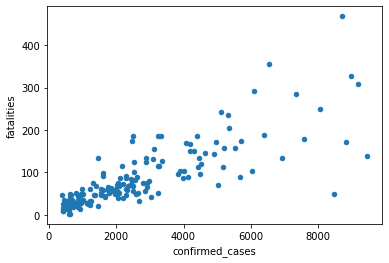

In [11]:
df1.plot.scatter(x = "confirmed_cases",
                y = "fatalities");

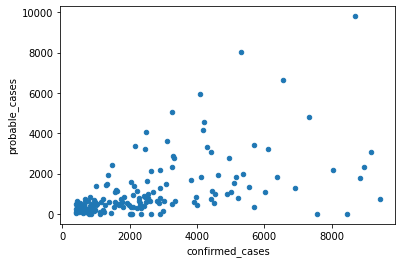

In [12]:
df1.plot.scatter(x = 'confirmed_cases',
                y = 'probable_cases');

<AxesSubplot:xlabel='probable_cases', ylabel='fatalities'>

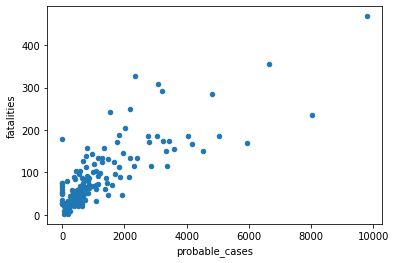

In [13]:
df1.plot.scatter(x = 'probable_cases',
                y = 'fatalities')

array([[<AxesSubplot:title={'center':'confirmed_cases'}>,
        <AxesSubplot:title={'center':'probable_cases'}>],
       [<AxesSubplot:title={'center':'fatalities'}>, <AxesSubplot:>]],
      dtype=object)

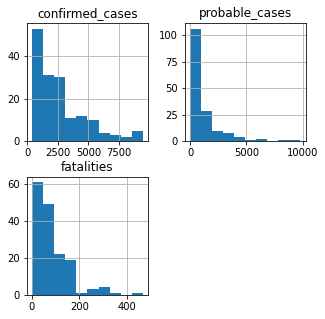

In [14]:
df1.hist(figsize=(5,5))

Data is highly right skewed, however, maps much better in terms of scatter and we can see a relationship between the data now after dimensionality reduction.

<AxesSubplot:>

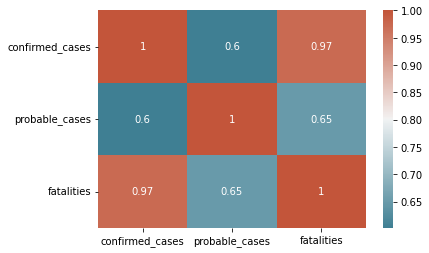

In [15]:
import seaborn as sns
# Create a correlation matrix
corr = df.corr()

# Plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

<AxesSubplot:>

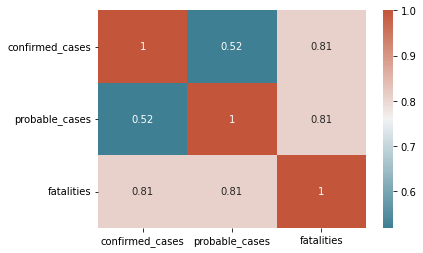

In [16]:
corr = df1.corr()

# Plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [17]:
#df.reset_index(drop=True, inplace=True)
ProfileReport(df)

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


County has high cardinality. This is due to the fact this is a report by county. Each field is correlated to one another. This could add a bit of data leakage as the model performs on unseen data. Dropping the index may help with accuracy(NOTE: dropping index did not improve or lower accuracy counts)

## Stat Modeling
* OLS
* LRM

In [18]:
ols_model = ols('confirmed_cases ~ fatalities', data=df).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:        confirmed_cases   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     4529.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):          4.62e-163
Time:                        10:33:56   Log-Likelihood:                -2729.7
No. Observations:                 254   AIC:                             5463.
Df Residuals:                     252   BIC:                             5471.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2447.5985    745.906     -3.281      0.0

In [19]:
ols_model1 = ols('confirmed_cases ~ fatalities', data=df1).fit()
print(ols_model1.summary())

                            OLS Regression Results                            
Dep. Variable:        confirmed_cases   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     302.9
Date:                Thu, 07 Oct 2021   Prob (F-statistic):           1.18e-38
Time:                        10:33:56   Log-Likelihood:                -1375.1
No. Observations:                 161   AIC:                             2754.
Df Residuals:                     159   BIC:                             2760.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    657.8131    150.884      4.360      0.0

In [20]:
from sklearn.model_selection import train_test_split
target = 'fatalities'
x = df.drop(columns = {target, 'county'})
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(x,y, test_size=0.2, random_state=42)

In [21]:
target = 'fatalities'
x1 = df1.drop(columns = {target, 'county'})
y1 = df1[target]

X_train1, X_val1, y_train1, y_val1 = train_test_split(x1,y1, test_size=0.2, random_state=42)

In [22]:
from sklearn.metrics import mean_absolute_error

y_pred = [y_train.mean()] * len(y_train) 

mean_absolute_error(y_train, y_pred)
y_pred

print('Baseline MAE is:', mean_absolute_error(y_train, y_pred))
print('Length of X_train:', len(X_train), X_train.shape)
print('Length of y_train:', len(y_train), y_train.shape)
print("Length of y_pred:", len(y_pred))

Baseline MAE is: 875.1265859284891
Length of X_train: 204 (204, 2)
Length of y_train: 204 (204,)
Length of y_pred: 204


In [23]:
y_pred1 = [y_train1.mean()] * len(y_train1) 

mean_absolute_error(y_train1, y_pred1)
y_pred1

print('Baseline MAE is:', mean_absolute_error(y_train1, y_pred1))
print('Length of X_train:', len(X_train1), X_train1.shape)
print('Length of y_train:', len(y_train1), y_train1.shape)
print("Length of y_pred:", len(y_pred1))

Baseline MAE is: 53.069580078125
Length of X_train: 128 (128, 2)
Length of y_train: 128 (128,)
Length of y_pred: 128


* Need to instantate an encoder for the county column or drop it for linear equations. Can't parse the counties into a floating point value with multiple words.
* Cleaning and dimension reduction brought baseline from 875 -> 53.

In [24]:
# Step 1: Import the predictor class
from sklearn.linear_model import LinearRegression

# Step 2: Instantiate the class
model1 = LinearRegression()

# Step 3: Fit the predictor to the model
model1.fit(X_train, y_train)

# Step 4: Test your model


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Throws error at us about size of value being too large to be input to a float. Needs to be run through preprocessor before it can be used or normalized!

In [26]:
# Step 1: Import the predictor class
from sklearn.linear_model import LinearRegression

# Step 2: Instantiate the class
model = LinearRegression()

# Step 3: Fit the predictor to the model
model.fit(X_train1, y_train1)

# Step 4: Test your model

LinearRegression()

In [27]:
print("Training MAE:",mean_absolute_error(y_train1, model.predict(X_train1)))
print("Test MAE:",mean_absolute_error(y_val1, model.predict(X_val1)))

Training MAE: 20.185916505182384
Test MAE: 12.245086056767668


This is much much better than our baseline MAE. We could also run through the preprocessor to get that MAE better.

* Play with a couple different models today. XGBoost and probably RFC and DTC. They make these in a regressor model which we can run our encoded data through
* Model is finally performing better to testing data than it is to training data!

In [25]:
df1.to_csv('COVID_case_count_data.csv')